# Example of eSQG reconstruction 
## from NATL60 SSH map in Azores region

In [26]:
import numpy as np
import pylab as plt
import sys, os 
import xarray as xr 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import or3d.class_vertical_reconstruction as vr

## 1. Download SSH field and depth

In [3]:
path_ssh = '../data/SSH_fields/NATL60OSMO-CJM165_y2013m01d15.1h_SSH.nc'    
with xr.open_dataset(path_ssh, mask_and_scale=True) as (ds_2):   
        ssh = np.zeros_like(ds_2.sossheig[0,20:-20,20:-20])#153:-153,165:-164])  
        ssh[:,:] = np.mean(ds_2.sossheig[0:24,:,:],0)[20:-20,20:-20]#153:-153,165:-164] 
        lon = np.zeros_like(ds_2.nav_lon[20:-20,20:-20])#153:-153,165:-164] )   
        lon[:,:] = ds_2.nav_lon[20:-20,20:-20]#153:-153,165:-164]   
        lat = np.zeros_like(ds_2.nav_lat[20:-20,20:-20])#153:-153,165:-164] )   
        lat[:,:] = ds_2.nav_lat[20:-20,20:-20]#153:-153,165:-164]    
ssh = np.ma.masked_invalid(ssh)

depth = []
with open('../data/NATL60_depth.txt') as fp:
    for cnt, line in enumerate(fp):
        if cnt != 0 and cnt < 109:
            depth.append(np.float(line.strip()))
            
np.shape(ssh)

(866, 489)

Text(0.5,0,'N$_0$ (/f)')

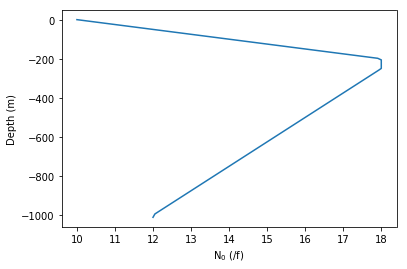

In [52]:
# N on the vertical
nz = np.shape(depth)[0]
corr_N = np.zeros(nz)  
depth_s = 0
depth0 = 200
depth1 = 250
depth2 = 1000
for iz in range(nz):
    if depth[iz]>=-depth_s:
        corr_N[iz] = 10
    elif depth[iz]>=-depth0:
        corr_N[iz] = 10*np.abs(depth[iz]+depth0)/(depth0-depth_s) + 18*np.abs(depth[iz]+depth_s)/(depth0-depth_s)
    elif depth[iz]>=-depth1:
        corr_N[iz] = 18
    elif depth[iz]<-depth2:
        corr_N[iz] = 12
    else: 
        corr_N[iz] = 18*np.abs(depth[iz]+depth2)/(depth2-depth1) + 12*np.abs(depth[iz]+depth1)/(depth2-depth1)

plt.plot(corr_N,depth)
plt.ylabel('Depth (m)')
plt.xlabel('N$_0$ (/f)')

## 2. Create an ocean reconstruction instance

In [53]:
my_esqg_reconstruction = vr.vertical_reconstruction()

## 3. Enter reconstruction parameters

In [54]:
my_esqg_reconstruction.ssh = ssh 
my_esqg_reconstruction.lon = lon
my_esqg_reconstruction.lat = lat 
my_esqg_reconstruction.z = depth
my_esqg_reconstruction.N0 = 2*2*np.pi/86164*np.sin(lat*np.pi/180)                                    
my_esqg_reconstruction.C = 3#2.6                                            
my_esqg_reconstruction.sppad = 3
my_esqg_reconstruction.corrN = corr_N

## 4. Run the eSQG reconstruction 

In [55]:
my_esqg_reconstruction.run_esqg()

## 5. Plot the reconstructed variables

Plotting surface variable
SSD anomaly is not available for plotting
SST anomaly is not available for plotting
Plotting 3D variables


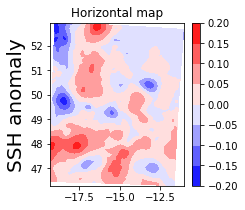

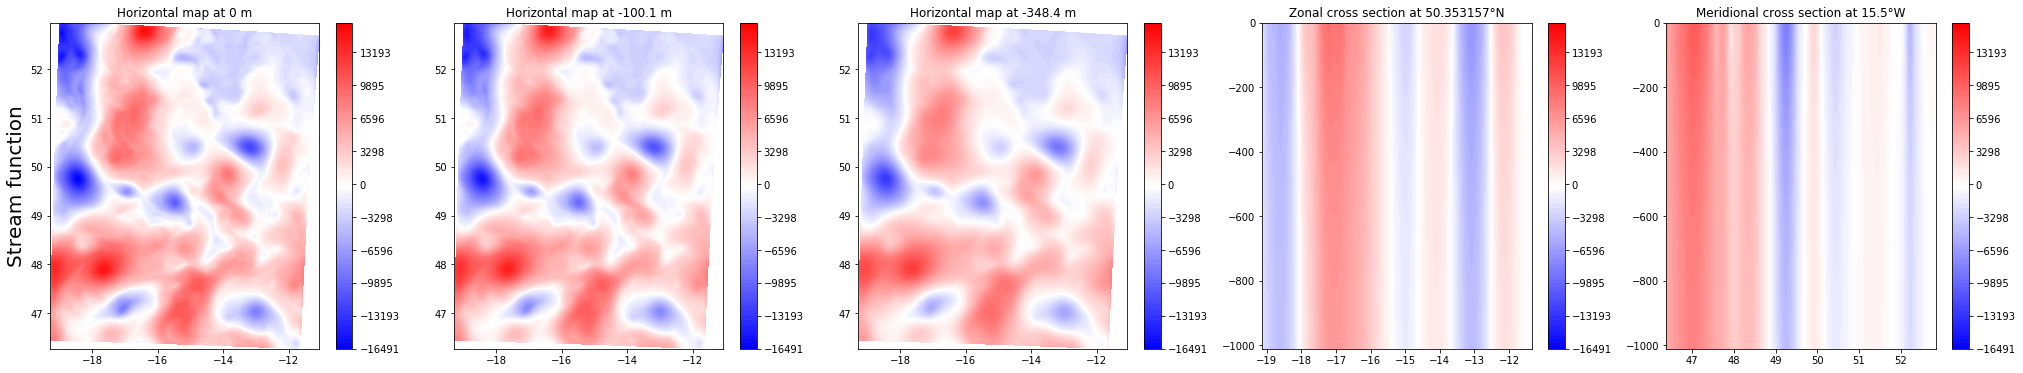

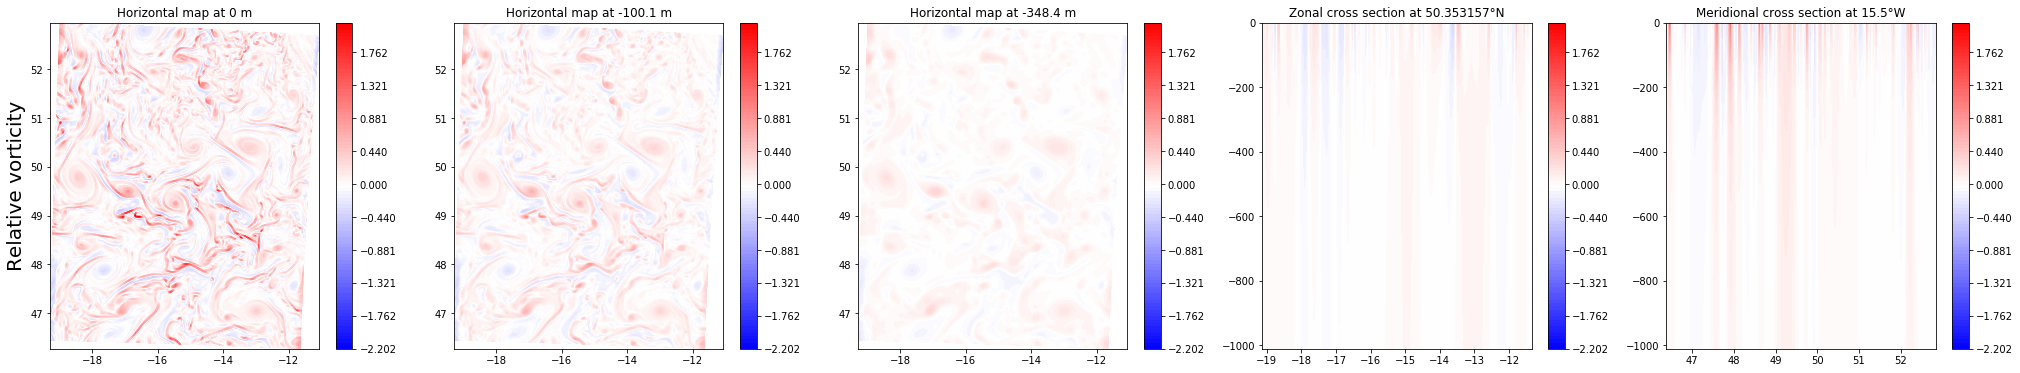

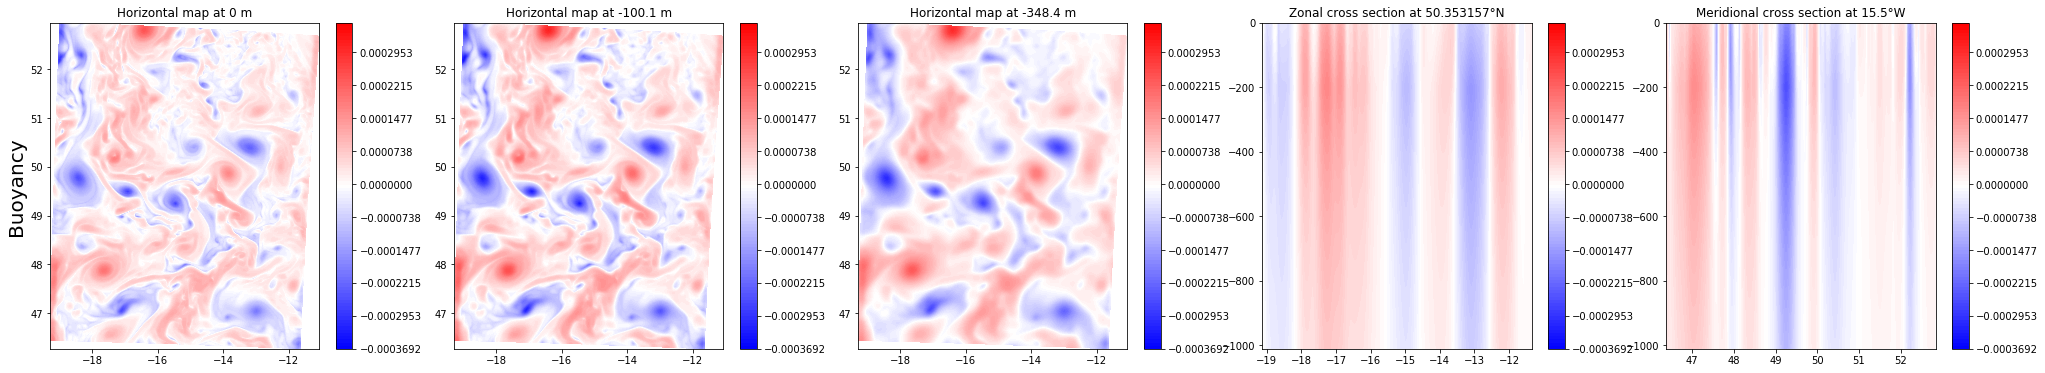

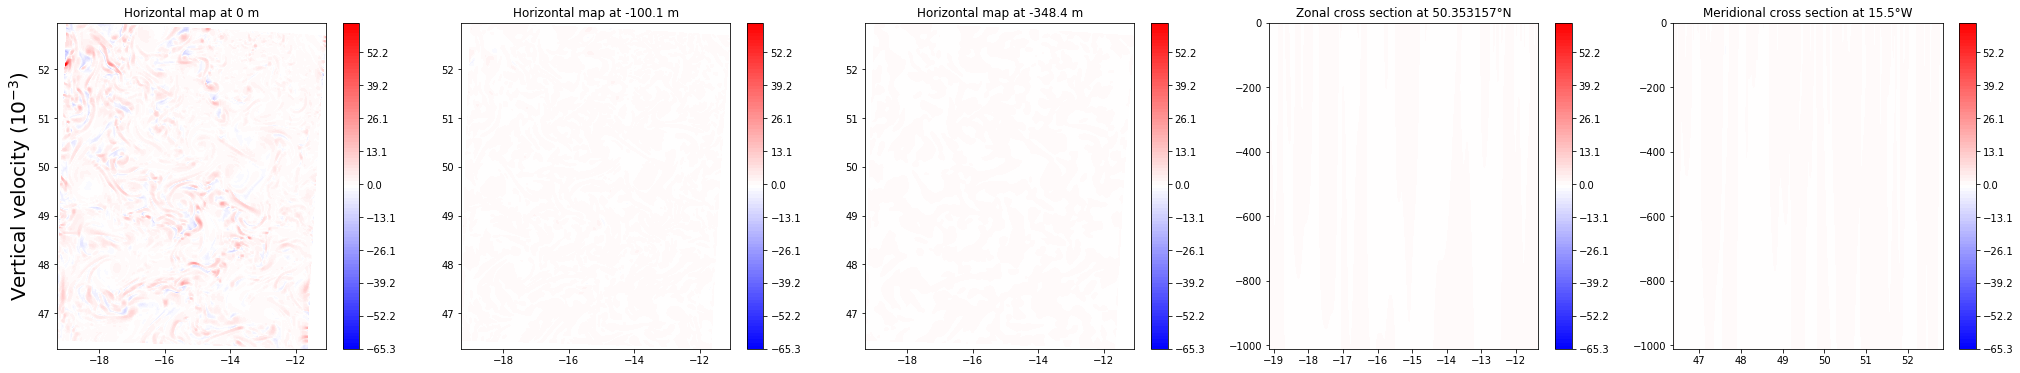

In [56]:
my_esqg_reconstruction.plot_reconstruction_outputs(crop1 = 100, crop2 = -200, crop3 = 20, crop4 = -20)

## 6. Compare reconstructed w to the reference

In [57]:
path_ref = '../data/Reference/NATL60OSM-CJM165_y2013m01d15.1d_W.nc'    
with xr.open_dataset(path_ref, mask_and_scale=True) as (ds_2):   
        w_ref = np.zeros_like(ds_2.vovecrtz[0,:my_esqg_reconstruction.nz,:,:])    
        w_ref[:,:] = ds_2.vovecrtz[0,:my_esqg_reconstruction.nz,:,:] 
        lon_ref = np.zeros_like(ds_2.nav_lon[:,:] )   
        lon_ref[:,:] = ds_2.nav_lon[:,:]   
        lat_ref = np.zeros_like(ds_2.nav_lat[:,:] )   
        lat_ref[:,:] = ds_2.nav_lat[:,:]    
        
w_ref = np.ma.masked_invalid(w_ref)

ncrop5 = 2
ncrop6 = -161
ncrop7 = 69
ncrop8 = -149

In [58]:
crop1 = 100+153-18
crop2 = -200-153+22
crop3 = 20+165-24
crop4 = -20-164+16

Text(0.5,1,'Meridional cross section at 375.5°W (10$^{-3}$m/s)')

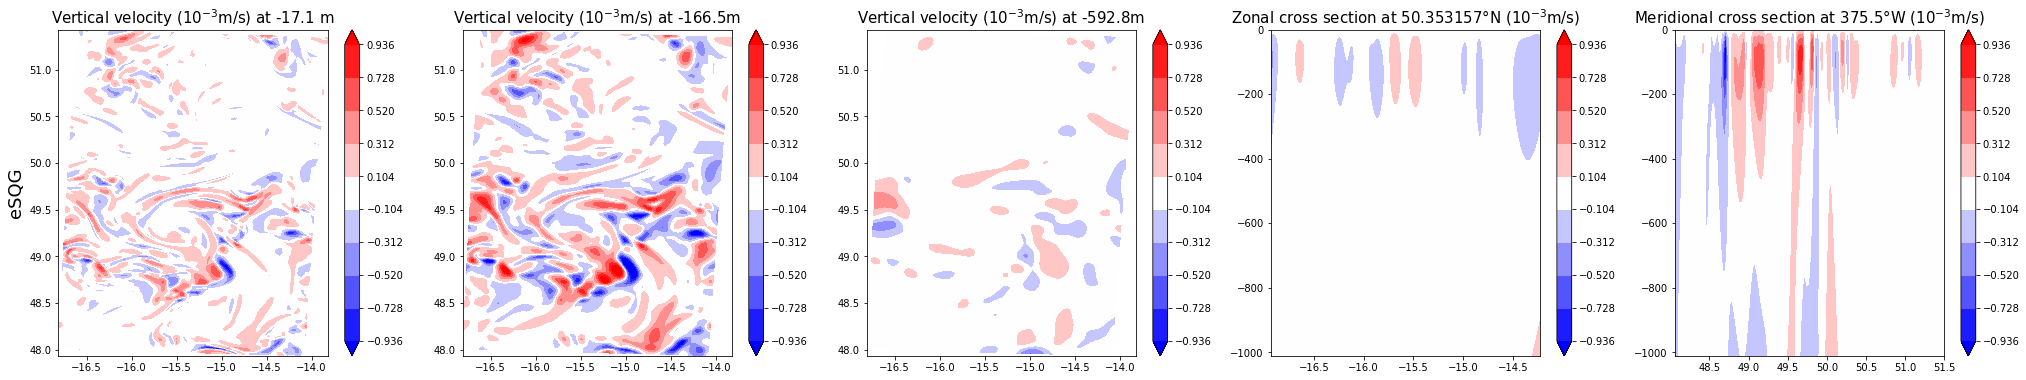

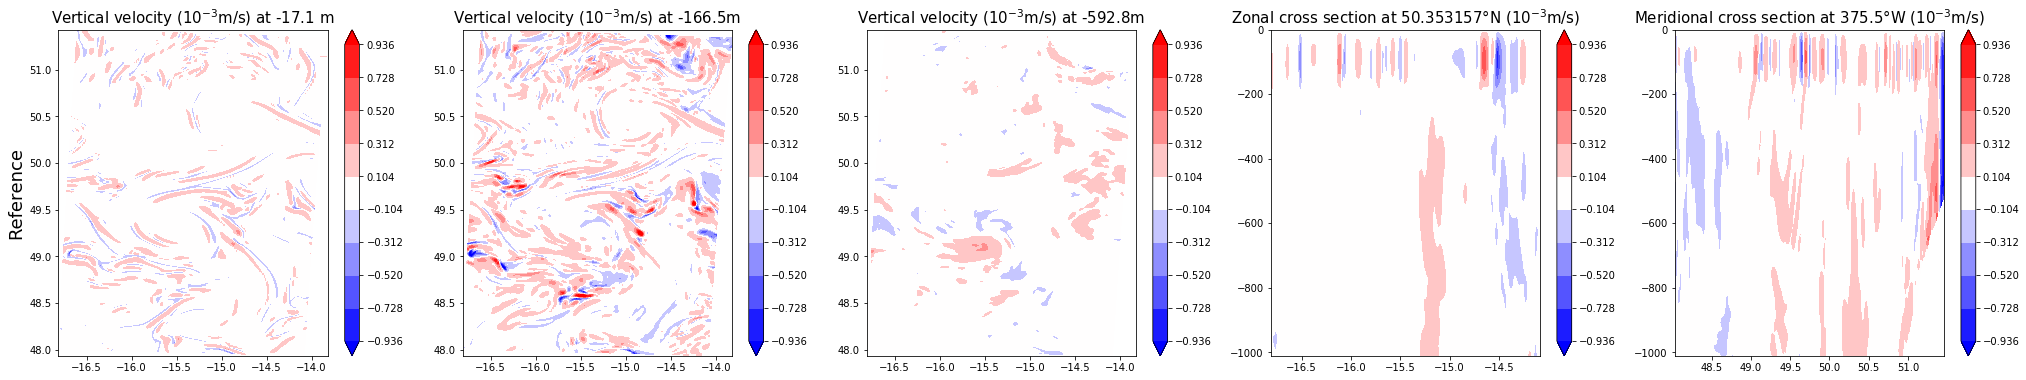

In [59]:
plt.figure(figsize=(35,6))
max_var = np.max(np.abs(w_ref[10,ncrop5:ncrop6,ncrop7:ncrop8]*1e3))
#max_var = np.max(np.abs(my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,10]))
levs = np.linspace(-max_var,max_var, 10)
plt.subplot(151)
plt.contourf(my_esqg_reconstruction.lon[crop1:crop2,crop3:crop4],my_esqg_reconstruction.lat[crop1:crop2,crop3:crop4],my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,10],cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.ylabel('eSQG',fontsize=18)
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[10])+' m',fontsize=15)
plt.subplot(152)
#max_var = np.max(np.abs(my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,10]))
levs = np.linspace(-max_var,max_var, 10)
plt.contourf(lon[crop1:crop2,crop3:crop4],my_esqg_reconstruction.lat[crop1:crop2,crop3:crop4],my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,40],cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[40])+'m',fontsize=15)
plt.subplot(153)
#max_var = np.max(np.abs(my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,10]))
levs = np.linspace(-max_var,max_var, 10)
plt.contourf(my_esqg_reconstruction.lon[crop1:crop2,crop3:crop4],my_esqg_reconstruction.lat[crop1:crop2,crop3:crop4],my_esqg_reconstruction.vertvel[crop1:crop2,crop3:crop4,80],cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[80])+'m',fontsize=15)
plt.subplot(154)
plt.contourf(my_esqg_reconstruction.lon[1,crop3:crop4],my_esqg_reconstruction.z[:],np.transpose(my_esqg_reconstruction.vertvel[int(my_esqg_reconstruction.nx/2),crop3:crop4,:]),cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Zonal cross section at '+str(my_esqg_reconstruction.lat[int(my_esqg_reconstruction.nx/2),1])+'°N (10$^{-3}$m/s)',fontsize=15)
plt.subplot(155)
plt.contourf(my_esqg_reconstruction.lat[crop1:crop2,1],my_esqg_reconstruction.z[:],np.transpose(my_esqg_reconstruction.vertvel[crop1:crop2,int(my_esqg_reconstruction.ny/2),:]),cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Meridional cross section at '+str("%.1f" % np.abs(my_esqg_reconstruction.lon[1,int(my_esqg_reconstruction.ny/2)]-360))+'°W (10$^{-3}$m/s)',fontsize=15)
 
max_var = np.max(np.abs(w_ref[10,ncrop5:ncrop6,ncrop7:ncrop8]*1e3))
levs = np.linspace(-max_var,max_var, 10)
plt.figure(figsize=(35,6))
plt.subplot(151)
plt.contourf(lon_ref[ncrop5:ncrop6,ncrop7:ncrop8],lat_ref[ncrop5:ncrop6,ncrop7:ncrop8],w_ref[10,ncrop5:ncrop6,ncrop7:ncrop8]*1e3,cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.ylabel('Reference',fontsize=18)
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[10])+' m',fontsize=15)
plt.subplot(152)
plt.contourf(lon_ref[ncrop5:ncrop6,ncrop7:ncrop8],lat_ref[ncrop5:ncrop6,ncrop7:ncrop8],w_ref[40,ncrop5:ncrop6,ncrop7:ncrop8]*1e3,cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[40])+'m',fontsize=15)
plt.subplot(153)
plt.contourf(lon_ref[ncrop5:ncrop6,ncrop7:ncrop8],lat_ref[ncrop5:ncrop6,ncrop7:ncrop8],w_ref[90,ncrop5:ncrop6,ncrop7:ncrop8]*1e3,cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar() 
plt.title('Vertical velocity (10$^{-3}$m/s) at '+str("%.1f" %my_esqg_reconstruction.z[80])+'m',fontsize=15)
plt.subplot(154)
plt.contourf(lon_ref[1,ncrop7:ncrop8],my_esqg_reconstruction.z[:], w_ref[:,int(np.shape(w_ref)[1]/2),ncrop7:ncrop8]*1e3,cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Zonal cross section at '+str(my_esqg_reconstruction.lat[int(my_esqg_reconstruction.nx/2),1])+'°N (10$^{-3}$m/s)',fontsize=15)
plt.subplot(155)
plt.contourf(lat_ref[ncrop5:ncrop6,1],my_esqg_reconstruction.z[:],w_ref[:,ncrop5:ncrop6,int(np.shape(w_ref)[2]/2)]*1e3,cmap=plt.cm.get_cmap('bwr'),levels=levs,extend='both')
plt.colorbar()
plt.title('Meridional cross section at '+str("%.1f" % np.abs(my_esqg_reconstruction.lon[1,int(my_esqg_reconstruction.ny/2)]-360))+'°W (10$^{-3}$m/s)',fontsize=15)

In [12]:
#/mnt/meom/MODEL_SET/NATL60/NATL60-CJM165-S/OSM/NATL60OSM-CJM165_y2013m01d15.1d_W.nc
#/mnt/meom/MODEL_SET/NATL60/NATL60-CJM165-S/OSMOSIS/NATL60OSMO-CJM165_y2013m01d15.1h_SSH.nc